In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_new = pd.DataFrame()

for i in range(0, 18):

    url = "https://www.pro-football-reference.com/years/2023/week_"+str(i+1)+".htm"    
    data = pd.read_html(url, encoding='UTF-8')
    
    if len(data) >= 2:  # Verificamos si hay al menos 2 tablas
        data0 = data[0]
        data1 = data[1]
        data_new = pd.concat([data_new, data0, data1])

        for j in range(2, min(32, len(data)), 2):  # Aseguramos que el índice no exceda el tamaño de 'data'
            if j+1 < len(data):  # Verificamos si el índice j+1 es válido
                data_update = pd.concat([data_new, data[j], data[j+1]])
                data_new = data_update

data_new.index = [i % 6 for i in range(len(data_new))]

data1 = pd.DataFrame({

    'Equipo Local':[x for x in data_new[0][1]],
    'Score Local':[x for x in data_new[1][1]],
    'Equipo Visitante':[x for x in data_new[0][2]],
    'Score Visitante':[x for x in data_new[1][2]],
    'Fecha':[x for x in data_new[0][0]],
    'PassYds':[x for x in data_new[1][3]],
    'Yds':[x for x in data_new[2][3]],
    'RushYds':[x for x in data_new[1][4]],
    'Yds1':[x for x in data_new[2][4]],
    'RecYds':[x for x in data_new[1][5]],
    'Yds2':[x for x in data_new[2][5]],
})
semanas = ['sem' + str(i // 16 + 1) for i in range(len(data1))]
data1['semana'] = semanas
data1

,Equipo Local,Score Local,Equipo Visitante,Score Visitante,Fecha,PassYds,Yds,RushYds,Yds1,RecYds,Yds2,semana
0,Detroit Lions,21,Kansas City Chiefs,20,"Sep 7, 2023",Goff-DET,253,Montgomery-DET,74,Reynolds-DET,80,sem1
1,Carolina Panthers,10,Atlanta Falcons,24,"Sep 10, 2023",Young-CAR,146,Allgeier-ATL,75,Pitts-ATL,44,sem1
2,Cincinnati Bengals,3,Cleveland Browns,24,"Sep 10, 2023",Watson-CLE,154,Chubb-CLE,106,Moore-CLE,43,sem1
3,Jacksonville Jaguars,31,Indianapolis Colts,21,"Sep 10, 2023",Lawrence-JAX,241,Etienne-JAX,77,Ridley-JAX,101,sem1
4,Tampa Bay Buccaneers,20,Minnesota Vikings,17,"Sep 10, 2023",Cousins-MIN,344,White-TAM,39,Jefferson-MIN,150,sem1
...,...,...,...,...,...,...,...,...,...,...,...,...
267,Denver Broncos,14,Las Vegas Raiders,27,"Jan 7, 2024",Stidham-DEN,272,White-LVR,112,Johnson-DEN,88,sem17
268,Kansas City Chiefs,13,Los Angeles Chargers,12,"Jan 7, 2024",Stick-LAC,258,Stick-LAC,77,Parham-LAC,83,sem17
269,Los Angeles Rams,21,San Francisco 49ers,20,"Jan 7, 2024",Darnold-SFO,189,Wentz-LAR,56,Conley-SFO,69,sem17
270,Dallas Cowboys,38,Washington Commanders,10,"Jan 7, 2024",Prescott-DAL,279,Pollard-DAL,70,Lamb-DAL,98,sem17


In [2]:
data_rams = data1[(data1['Equipo Local']=='Los Angeles Rams')|(data1['Equipo Visitante']=='Los Angeles Rams')].reset_index(drop=True)


In [3]:
data_rams['Score Local'] = pd.to_numeric(data_rams['Score Local'])
data_rams['Score Visitante'] = pd.to_numeric(data_rams['Score Visitante'])

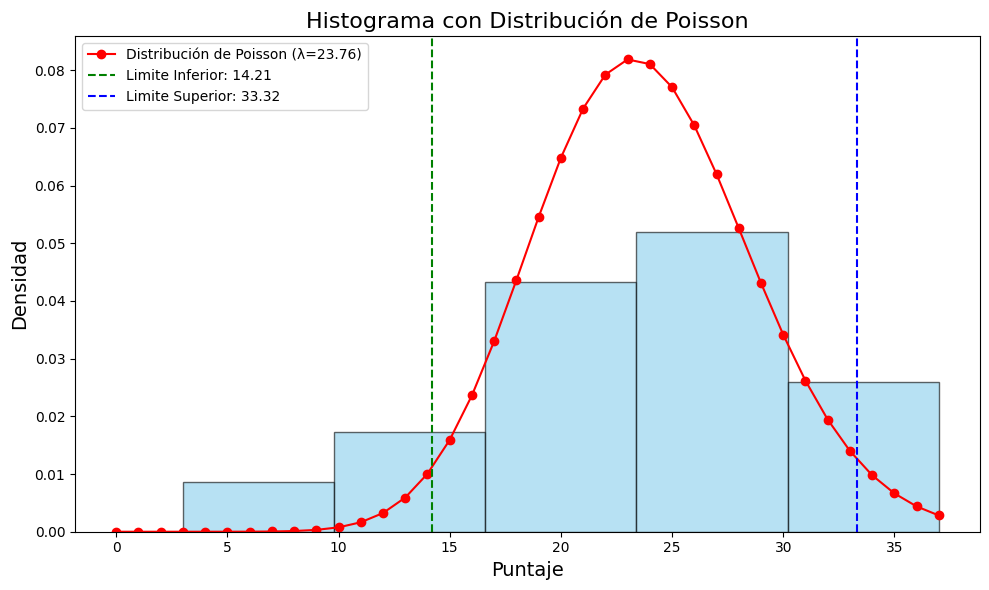

In [4]:
from scipy.stats import poisson, norm

puntajes = pd.concat([
    data_rams[data_rams['Equipo Local'] == 'Los Angeles Rams']['Score Local'], 
    data_rams[data_rams['Equipo Visitante'] == 'Los Angeles Rams']['Score Visitante']
])

# Crear el histograma
plt.figure(figsize=(10, 6))
count, bins, _ = plt.hist(puntajes, bins=5, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Calcular la media de los puntajes (λ en Poisson)
lambda_poisson = np.mean(puntajes)

# Nivel de confianza (por ejemplo, 95%)
confidence_level = 0.95
z_value = norm.ppf(1 - (1 - confidence_level) / 2)  # Valor crítico de z (95% -> 1.96)

# Calcular los intervalos de confianza
lower_bound = lambda_poisson - z_value * np.sqrt(lambda_poisson)
upper_bound = lambda_poisson + z_value * np.sqrt(lambda_poisson)


# Generar valores de la distribución de Poisson
x = np.arange(0, max(puntajes)+1)
poisson_dist = poisson.pmf(x, lambda_poisson)

# Generar los límites del intervalo de confianza
poisson_dist = poisson.pmf(x, lambda_poisson)

# Graficar la distribución de Poisson sobre el histograma
plt.plot(x, poisson_dist, 'r', marker='o', linestyle='-', label=f'Distribución de Poisson (λ={lambda_poisson:.2f})')

# Graficar los intervalos de confianza
plt.axvline(lower_bound, color='green', linestyle='--', label=f'Limite Inferior: {lower_bound:.2f}')
plt.axvline(upper_bound, color='blue', linestyle='--', label=f'Limite Superior: {upper_bound:.2f}')

# Añadir etiquetas y título
plt.title('Histograma con Distribución de Poisson', fontsize=16)
plt.xlabel('Puntaje', fontsize=14)
plt.ylabel('Densidad', fontsize=14)

# Mostrar leyenda y gráfico
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import poisson

# Supongamos que la media de puntos por juego es 24
lambda_poisson = sum(puntajes)/len(puntajes)

# Calcular la probabilidad de que haya exactamente 28 puntos
puntos_objetivo = 26
probabilidad_poisson = poisson.pmf(puntos_objetivo, lambda_poisson)

print(f'Probabilidad de exactamente {puntos_objetivo} puntos: {probabilidad_poisson * 100:.2f}%')

Probabilidad de exactamente 26 puntos: 7.04%


# Rango de Puntaje usando poisson 

In [6]:
from scipy.stats import poisson

# Media de puntos (λ)
lambda_poisson = sum(puntajes)/len(puntajes)

# Definir el rango de puntajes
puntos_min = 20
puntos_max = 30

# Calcular la probabilidad acumulada hasta el puntaje máximo
prob_acumulada_max = poisson.cdf(puntos_max, lambda_poisson)

# Calcular la probabilidad acumulada hasta el puntaje mínimo
prob_acumulada_min = poisson.cdf(puntos_min - 1, lambda_poisson)

# La probabilidad de que el puntaje esté entre puntos_min y puntos_max
probabilidad_rango = prob_acumulada_max - prob_acumulada_min

print(f'Probabilidad de que el puntaje esté entre {puntos_min} y {puntos_max}: {probabilidad_rango * 100:.2f}%')

Probabilidad de que el puntaje esté entre 20 y 30: 71.96%


In [11]:
puntajes

0     30
2     16
3     29
7     20
8      3
10    37
12    31
15    26
16    21
1     23
4     14
5     26
6     17
9     17
11    36
13    28
14    30
dtype: int64